In [46]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch
from astropy.nddata import Cutout2D
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord, proj_plane_pixel_scales
from skimage.draw import ellipse
from photutils.segmentation import detect_sources


plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True

In [57]:
field = 'GDS'
detect_img=glob.glob(f'/home/ec2-user/DAWN/DJA-SEpp/image/{field}/*ir*sci_cutout_cutout.fits')[0]

In [58]:
with fits.open(detect_img, memmap=True) as hdul:
    wcs = WCS(hdul[0].header)
    mask = np.zeros(hdul[0].data.shape)
with fits.open(glob.glob(f"/home/ec2-user/DAWN/DJA-SEpp/image/{field}/dja/*fix_phot_apcorr.fits")[0], memmap=True) as hdul:
    phot_dja = Table(hdul[1].data)

In [59]:
# Calculate mean fluxes and mag for initial values in model fitting
filter_list = ['f115w','f150w','f277w','f444w']

flux_mean = 100*np.nanmean([phot_dja[f'{filter}_tot_1'] for filter in filter_list], axis=0)
mag_mean  = np.nanmean([(phot_dja[f'{filter}_tot_1']*1000*u.nJy).to(u.ABmag).value for filter in filter_list], axis=0)

flux_mean = np.nan_to_num(flux_mean, nan=np.nanmean(phot_dja['f277w_tot_1']))
mag_mean = np.nan_to_num(mag_mean, nan=25)

/home/ec2-user/miniconda3/envs/dawn-310/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/tmp/ipykernel_5413/2328303814.py:5: RuntimeWarning: Mean of empty slice
  mag_mean  = np.nanmean([(phot_dja[f'{filter}_tot_1']*1000*u.nJy).to(u.ABmag).value for filter in filter_list], axis=0)


In [60]:
# Create association catalog
data = Table()
data['ra'] = phot_dja['ra']                                    # 1
data['dec'] = phot_dja['dec']                                  # 2
data['group_id'] = np.arange(len(phot_dja))                    # 3
data['flux_mean']  = flux_mean                                 # 4
data['mag_mean'] = mag_mean                                    # 5
data['a_image'] = phot_dja['a_image']                          # 6
data['b_image'] = phot_dja['b_image']                          # 7
data['theta_image'] = phot_dja['theta_image']                  # 8
data['axratio'] = phot_dja['a_image']/phot_dja['b_image']      # 9
data['bigsize'] = phot_dja['a_image']*10                       # 10

px_scale = proj_plane_pixel_scales(wcs)[0]*3600
data['bigsize'][data['bigsize'] < 3] = 3
data['bigsize'][data['a_image'] > 2/px_scale] = 2/px_scale

In [61]:
# Create segmentation map
coord = SkyCoord(data['ra'], data['dec'], unit='deg')
coord_px = skycoord_to_pixel(coord, wcs)
coord_px_ra, coord_px_de = coord_px

for i in range(len(data)):
    if ((i+1) % 10000) == 0:
        print(f"{i+1:>6}/{len(data)}")
    rr, cc = ellipse(coord_px_de[i], coord_px_ra[i], 
                     r_radius=np.clip(data['b_image'][i]*4, 4, 200),
                     c_radius=np.clip(data['a_image'][i]*4, 4, 200), 
                     rotation=(-data['theta_image'][i]))
    inside = np.where((rr>=0)&(rr<mask.shape[0])&(cc>=0)&(cc<mask.shape[1]))[0]
    rr = rr[inside]
    cc = cc[inside]
    mask[rr, cc] = 1

segment_map = detect_sources(mask, threshold=0.1, npixels=1)

for i in range(len(data)):
    x = int(coord_px_ra[i])
    y = int(coord_px_de[i])
    if (x>=0) & (y>=0) & (x<mask.shape[1]) & (y<mask.shape[0]):
        if mask[y, x] == 1:
            data[i]['group_id'] = int(segment_map.data[y, x])
    else:
        data[i]['group_id'] = -1
data = data[data['group_id']>0]

 10000/70357
 20000/70357
 30000/70357
 40000/70357
 50000/70357
 60000/70357
 70000/70357


In [62]:
# Save segmentation map
fname = ".".join(detect_img.split("/")[-1].split(".")[:-1])
with fits.open(detect_img, memmap=True) as hdul:
    hdul[0].data = segment_map.data
    hdul.writeto(f"/home/ec2-user/DAWN/DJA-SEpp/catalog/{field}/{fname}_seg.fits", overwrite=True)
with open(f"/home/ec2-user/DAWN/DJA-SEpp/catalog/{field}/{fname}_seg_cmap.pkl", 'wb') as file:
    pickle.dump(segment_map.cmap, file)

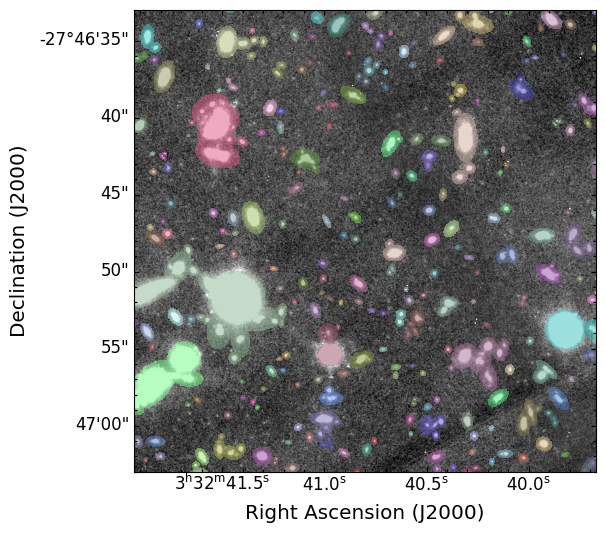

In [64]:
# Show segmentation map cutout
hdu = fits.open(detect_img, memmap=True)[0]
wcs = WCS(hdu.header)

seg_hdu = fits.open(f"/home/ec2-user/DAWN/DJA-SEpp/catalog/{field}/{fname}_seg.fits", memmap=True)[0]

with open(f"/home/ec2-user/DAWN/DJA-SEpp/catalog/{field}/{fname}_seg_cmap.pkl", 'rb') as file:
    cmap = pickle.load(file)

center = SkyCoord('53.17 -27.78', frame='icrs', unit='deg') # GDS
size=u.Quantity((0.5,0.5), u.arcmin)

cutout = Cutout2D(hdu.data, position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)
seg_cutout = Cutout2D(seg_hdu.data, position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)

fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':cutout.wcs})
norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
# norm = ImageNormalize(cutout.data, interval=MinMaxInterval(), stretch=LogStretch())
ax.imshow(cutout.data, cmap='gray', origin='lower', norm=norm)
ax.imshow(np.ma.masked_where(seg_cutout.data==0, seg_cutout.data), cmap=cmap, origin='lower', interpolation='none', alpha=0.5)
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
plt.show()

In [65]:
# Save association catalog
fname = ".".join(detect_img.split("/")[-1].split(".")[:-1])
ascii.write(data, f"/home/ec2-user/DAWN/DJA-SEpp/catalog/{field}/{fname}_assoc-cat.txt", 
            overwrite=True, delimiter='\t', comment='#', format="no_header")
print(data.keys())
print(len(data))

['ra', 'dec', 'group_id', 'flux_mean', 'mag_mean', 'a_image', 'b_image', 'theta_image', 'axratio', 'bigsize']
332


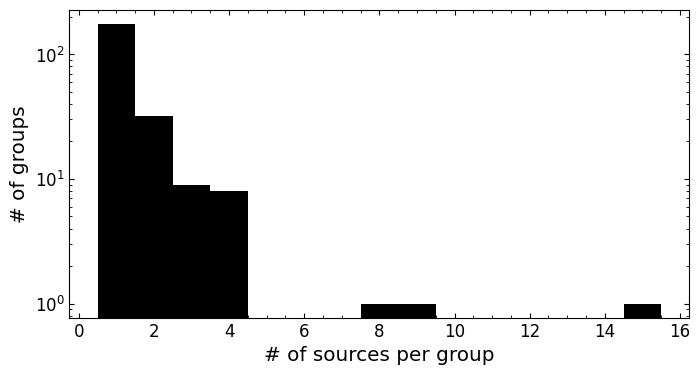

In [66]:
count_group = np.unique(data['group_id'], return_counts=True)[1]
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(count_group, bins=min(np.max(count_group)-1,100), log=True, align='left', histtype='stepfilled', color='k')
ax.set_xlabel("# of sources per group")
ax.set_ylabel("# of groups")
plt.show()

In [67]:
# Sorts the catalog by increasing distance from center (useful for incomplete run of SE++)
center = SkyCoord(np.mean(data['ra']), np.mean(data['dec']), unit='deg')
coord = SkyCoord(data['ra'], data['dec'], unit='deg')
dist = center.separation(coord).value
sort = np.argsort(dist)
data_sort = data[sort]
ascii.write(data_sort, f"/home/ec2-user/DAWN/DJA-SEpp/catalog/{field}/{fname}_assoc-cat_sort.txt", 
            overwrite=True, delimiter='\t', comment='#', format="no_header")